# Analysis of Hate Crimes In United States
By: Olivia Xia and Divya Koganti

## Introduction
Our tutorial will go through the entire data science pipeline through anlyzing hate crime in the United States. The data science pipeline is data collection, data processing, exploratory & data visualization, analysis & hypothesis testing & ML, and insight & policy decision. 
### Importance
Hate crimes have sadly been part of United States history and continues to be a large part of our present news as well. For example, the more recent wave of hate crimes against asians during the covid pandemic. Another example the black lives matter movement that has been continuously part of our present news. By analyzing the hate crime data, we can help determine trends in hate crimes, provide lawmakers with justification for policies, and show the issues in our communities in relation to hate crimes.
### Background
A hate crime is crime that is motivated by bias against race, religion, disability, sexual orientation, ethnicity, gender or gender identity.


#### Imports

The libraries that are used will be explained more when put to use. For now just import the libraries

In [15]:
#data structures
import pandas as pd

#data vizualization
import matplotlib.pyplot as plt
import seaborn as sb

#math
import numpy as np

#Machine learning algorithms and more
import statsmodels as sm

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Collection
Data collection is looking for data that fits our topic. The data needs to reliable otherwise any conclusions or analysis we do will be wrong. We got the data from the FBI database of hate crime data, which was gotten through the [Uniform Crime Reporting](https://www.fbi.gov/services/cjis/ucr) (UCR) program that generates reliable statistics for law enforcement. The UCR program gets data from every law enforcement agencies in the country. We downloaded the hate crimes data from [FBI Crime Data Explorer](https://crime-data-explorer.app.cloud.gov/pages/downloads). The data contains every incident of hate crimes recorded since 1991.

Here we are taking the data from a csv file which means a comma separated values and creating a pandas dataframe with the values. 

In [16]:
hate_crimes = pd.read_csv("hate_crime.csv")
hate_crimes.head(5)

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


## Data Cleaning
We have data but the data needs to be formated and organized for the later steps of the data science pipeline. 

**removing unneeded columns**

In [17]:
def remove_columns(data):
    del data['ORI']
    del data['INCIDENT_ID']
    del data['PUB_AGENCY_NAME']
    del data['PUB_AGENCY_UNIT']
    del data['AGENCY_TYPE_NAME']
    del data['DIVISION_NAME']
    del data['REGION_NAME']
    del data['POPULATION_GROUP_CODE']
    del data['POPULATION_GROUP_DESC']
    return data


**creating a new series classifying the bias based on the FBI classification system for biases**

In [18]:

def classify_bias(bias):
    classification = []
    race_ethnicity_ancestry = ["Anti-White","Anti-Black or African American","Anti-American Indian or Alaska Native","Anti-Asian","Anti-Native Hawaiian or Other Pacific Islander","Anti-Multiple Races, Group","Anti-Arab","Anti-Hispanic or Latino","Anti-Other Race/Ethnicity/Ancestry"]
    religion = ['Anti-Jewish','Anti-Atheism/Agnosticism','Anti-Catholic','Anti-Protestant','Anti-Islamic (Muslim)','Anti-Other Religion','Anti-Multiple Religions, Group','Anti-Mormon','Anti-Jehovah\'s Witness','Anti-Eastern Orthodox (Russian, Greek, Other)','Anti-Other Christian','Anti-Buddhist','Anti-Hindu','Anti-Sikh','Anti-Atheism/Agnosticism/etc.']
    sexual_orientation= ['Anti-Gay (Male)','Anti-Lesbian (Female)','Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)','Anti-Heterosexual','Anti-Bisexual']
    disability= ['Anti-Physical Disability','Anti-Mental Disability']
    gender= ['Anti-Male','Anti-Female']
    gender_identity= ['Anti-Transgender','Anti-Gender Non-Conforming']
    #type_of_bias= bias.apply(lambda x: x.split(";"))
    for i in bias:
        if i in race_ethnicity_ancestry:
            classification.append('Race/Ethnicity/Ancestry')
        elif i in religion:
            classification.append('Religion')
        elif i in sexual_orientation:
            classification.append('Sexual Orientation')
        elif i in disability:
            classification.append('Disability')
        elif i in gender:
            classification.append('Gender')
        elif i in gender_identity:
            classification.append('Gender Identity')
        else:
            classification.append('Multiple-Bias Incidents')
    return classification

In [19]:
hate_crimes['OFFENSE_NAME'] = hate_crimes['OFFENSE_NAME'].apply(lambda x: x.split(";", 1)[0])
result = hate_crimes.groupby('OFFENSE_NAME').first()
result['COUNT'] = hate_crimes['OFFENSE_NAME'].value_counts()
result.reset_index(inplace=True)
result = result[['OFFENSE_NAME','COUNT']]
hate_crimes = pd.merge(hate_crimes, result, on='OFFENSE_NAME', how='left')

We will use the functions to clean the data and create a new column. We will also drop data that is before 1994 because the first few years of reporting crime data might not be accurate

In [20]:
hate_crimes.drop(hate_crimes[hate_crimes['DATA_YEAR'] < 1994].index, inplace=True)
hate_crimes.reset_index(drop=True, inplace=True)
hate_crimes = remove_columns(hate_crimes)
bias_category = classify_bias(hate_crimes['BIAS_DESC'])
hate_crimes = hate_crimes.assign(BIAS_CATEGORY= bias_category)

In [21]:
hate_crimes.head(5)

,DATA_YEAR,STATE_ABBR,STATE_NAME,INCIDENT_DATE,ADULT_VICTIM_COUNT,JUVENILE_VICTIM_COUNT,TOTAL_OFFENDER_COUNT,ADULT_OFFENDER_COUNT,JUVENILE_OFFENDER_COUNT,OFFENDER_RACE,...,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS,COUNT,BIAS_CATEGORY
0,1994,AK,Alaska,07-APR-94,NaN,NaN,2,NaN,NaN,Black or African American,...,1,Intimidation,1.0,Residence/Home,Anti-White,Individual,S,S,65150,Race/Ethnicity/Ancestry
1,1994,AK,Alaska,24-APR-94,NaN,NaN,0,NaN,NaN,Unknown,...,1,Destruction/Damage/Vandalism of Property,1.0,Residence/Home,Anti-Black or African American,Individual,S,S,69577,Race/Ethnicity/Ancestry
2,1994,AK,Alaska,26-APR-94,NaN,NaN,2,NaN,NaN,Black or African American,...,1,Intimidation,1.0,Other/Unknown,Anti-White,Individual,S,S,65150,Race/Ethnicity/Ancestry
3,1994,AK,Alaska,26-APR-94,NaN,NaN,2,NaN,NaN,Black or African American,...,1,Intimidation,1.0,Other/Unknown,Anti-White,Individual,S,S,65150,Race/Ethnicity/Ancestry
4,1994,AK,Alaska,08-MAY-94,NaN,NaN,2,NaN,NaN,White,...,1,Simple Assault,1.0,Field/Woods,Anti-American Indian or Alaska Native,Individual,S,S,41745,Race/Ethnicity/Ancestry


## Data Visualization

Even though colors might seem to be just for aesthetic purposes and not practical, using the right color palette makes it easier to understand the data. In this case, we use a color palette from the seaborn library that is for categorical data and is circular color palette so no matter the amount of colors used the same color will not overlap. More information can be found on [Choosing Color Palettes](https://seaborn.pydata.org/tutorial/color_palettes.html) a tutorial in the seaborn documentation.

In [22]:
colors = sb.color_palette('husl')

**Hate Crimes over Time**
We are going to make a line plot to see how the amount of hate crimes changed over time. We will be using both seaborn library and matplotlib library in order to visualize the data throughtout this section and others. [Matplotlib](https://matplotlib.org/stable/index.html) is the library for creating visualization in python. [Seaborn](https://seaborn.pydata.org/introduction.html) is the library built upon Matplotlib and integrates with pandas data structures to make statustucal graphs in python. If you click on the links, they will send you to the documentation for both libraries which is very helpful.

In this specfic example, we will use seaborn lineplot


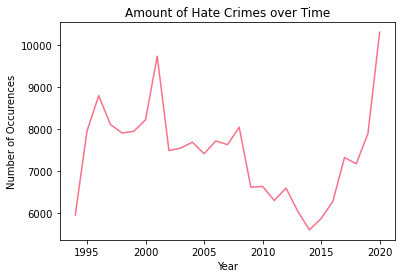

In [23]:
y=hate_crimes['DATA_YEAR'].value_counts()
x=hate_crimes['DATA_YEAR'].value_counts().index
sb.lineplot( x=x, y=y,color=colors[0])
plt.title("Amount of Hate Crimes over Time")
plt.xlabel("Year")
plt.ylabel("Number of Occurences")
plt.show()


**Looking at the types of biases**

Here we are exploring the data based the classification of biases. First looking at which hate crimes happen the most.

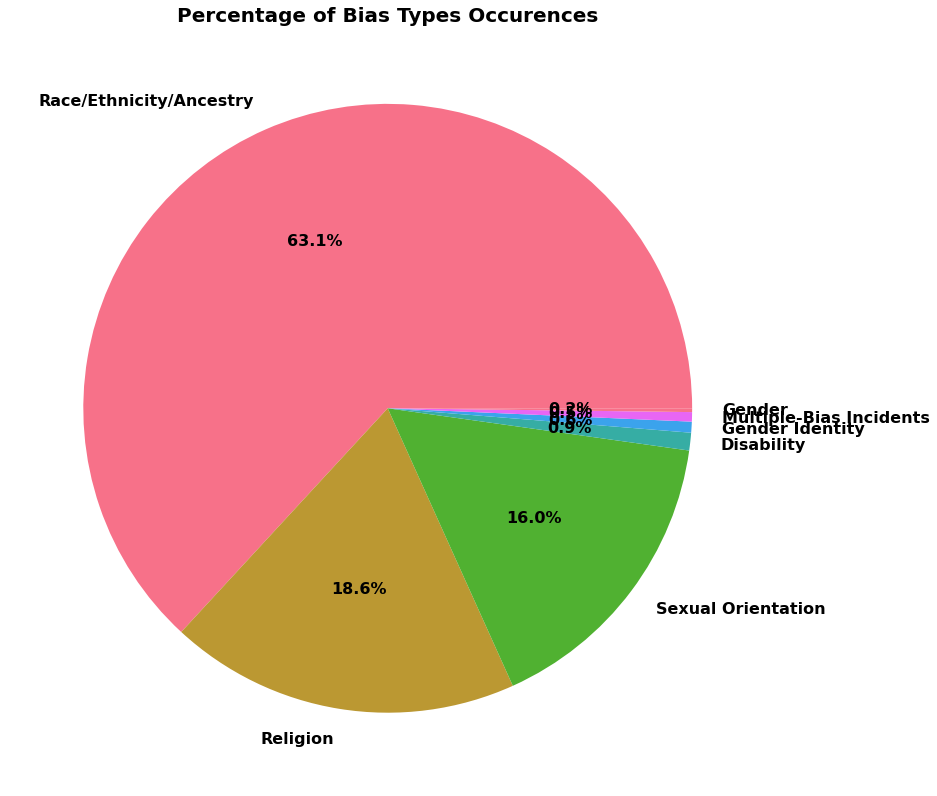

In [24]:
x = hate_crimes['BIAS_CATEGORY'].value_counts()
y = hate_crimes['BIAS_CATEGORY'].value_counts().index

plt.figure(figsize = (14, 14))
plt.pie(x,labels=y,autopct= '%.1f%%',textprops={'fontsize': 16, 'fontweight': "600"},colors=colors[0:6])
plt.title("Percentage of Bias Types Occurences",fontsize=20,fontweight= "600")
plt.show()

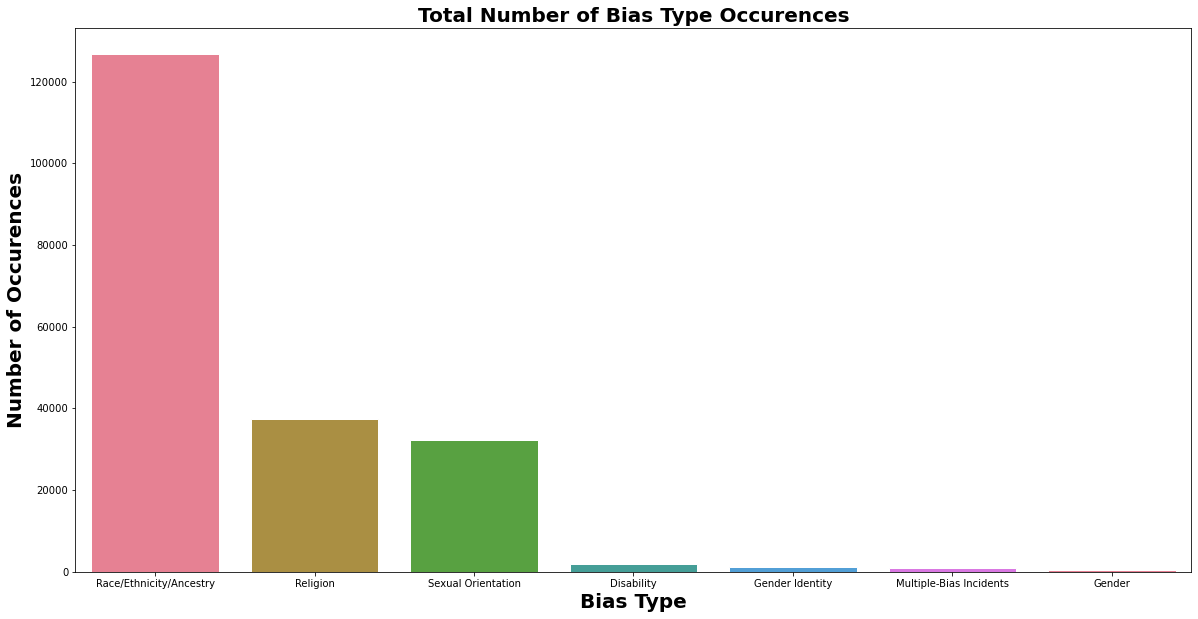

In [25]:
plt.figure(figsize = (20, 10))
plt.title("Total Number of Bias Type Occurences",fontsize=20,fontweight= "600")
sb.set()
count_bar = sb.barplot(x = y,y=x,palette= colors[0:6])
plt.xlabel("Bias Type",fontsize=20,fontweight= "600")
plt.ylabel("Number of Occurences",fontsize=20,fontweight= "600")
plt.show()

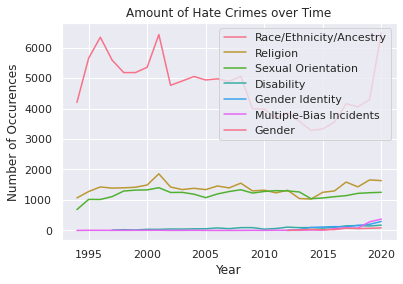

In [26]:
overall_bias = hate_crimes.groupby(['BIAS_CATEGORY'])
sb.set_palette(colors)
keys = ['Race/Ethnicity/Ancestry','Religion','Sexual Orientation','Disability','Gender Identity','Multiple-Bias Incidents','Gender']
for key in keys:
    years = overall_bias.get_group(key)['DATA_YEAR'].value_counts().index
    amount = overall_bias.get_group(key)['DATA_YEAR'].value_counts()
    sb.lineplot(years,amount,label=key)
plt.title("Amount of Hate Crimes over Time")
plt.xlabel("Year")
plt.ylabel("Number of Occurences")
plt.show()

**Looking at the Race/Ethnicity/Ancestry Bias types with a pie chart and  bar chart**

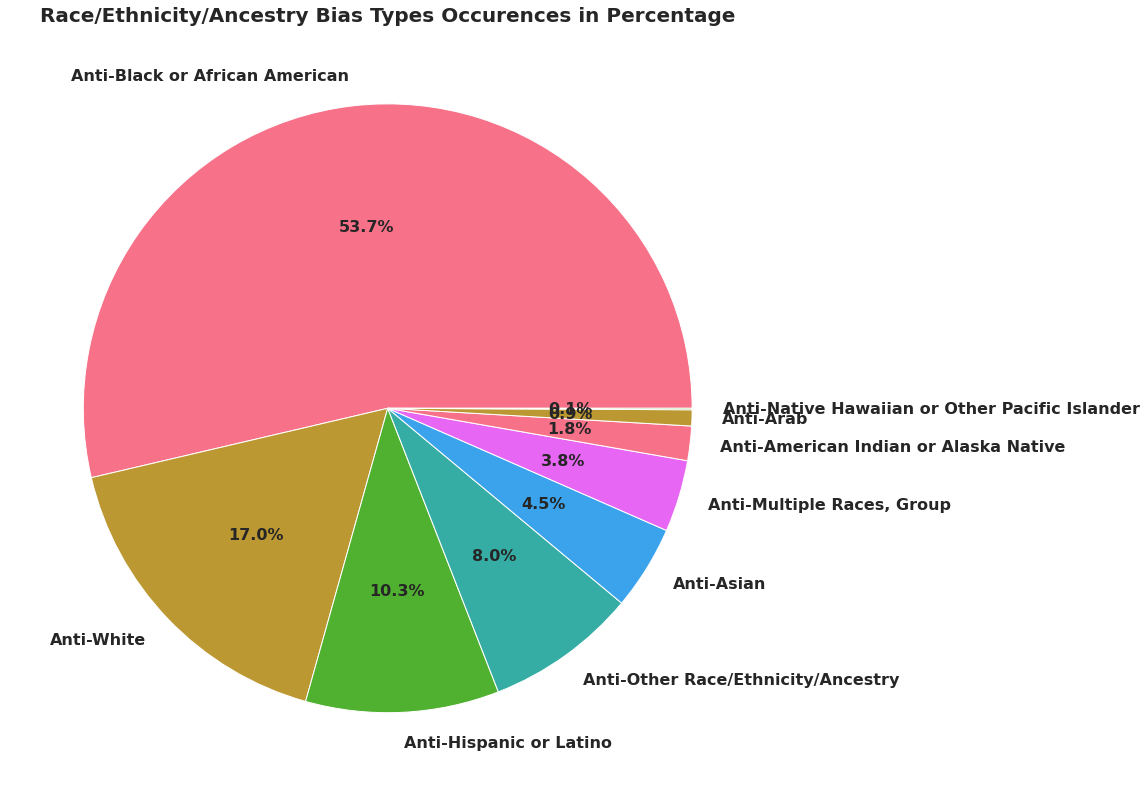

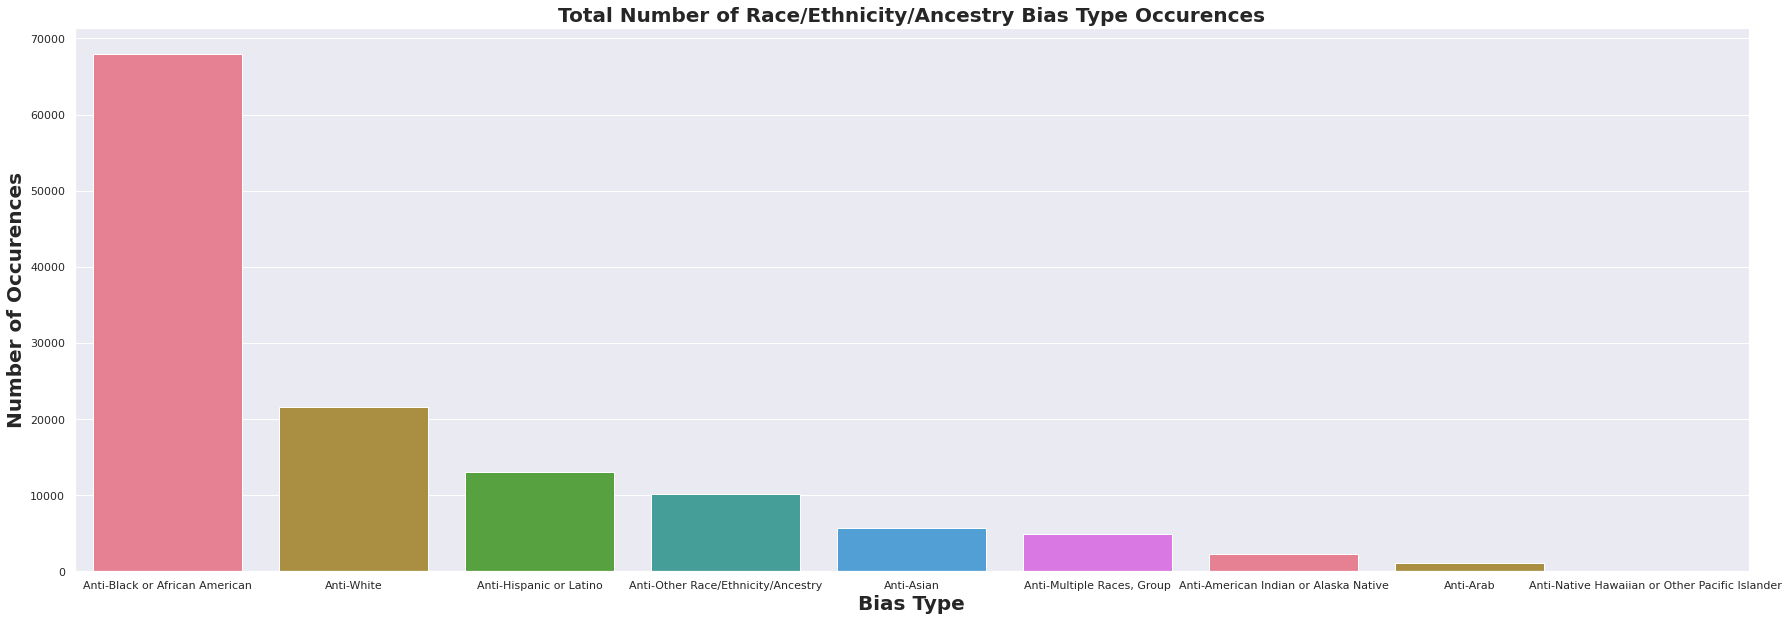

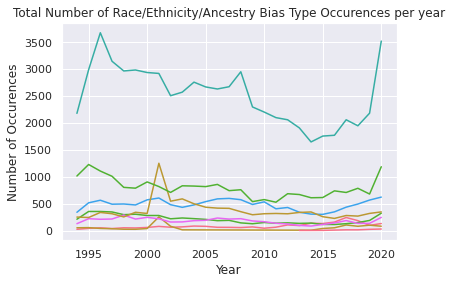

In [27]:
race_ethnicity_ancestry= hate_crimes.groupby('BIAS_CATEGORY').get_group('Race/Ethnicity/Ancestry')
x = race_ethnicity_ancestry['BIAS_DESC'].value_counts()
y = race_ethnicity_ancestry['BIAS_DESC'].value_counts().index
size = race_ethnicity_ancestry['BIAS_DESC'].value_counts().size

plt.figure(figsize = (14, 14))
plt.pie(x,labels=y,autopct= '%.1f%%',textprops={'fontsize': 16, 'fontweight': "600"},colors=colors)
plt.title("Race/Ethnicity/Ancestry Bias Types Occurences in Percentage",fontsize=20,fontweight= "600")
plt.show()

plt.figure(figsize = (30, 10))
plt.title("Total Number of Race/Ethnicity/Ancestry Bias Type Occurences",fontsize=20,fontweight= "600")
sb.set()
count_bar = sb.barplot(x = y,y=x,palette= colors)
plt.xlabel("Bias Type",fontsize=20,fontweight= "600")
plt.ylabel("Number of Occurences",fontsize=20,fontweight= "600")
plt.show()

grouped = race_ethnicity_ancestry.groupby(['BIAS_DESC'])
i = 0
sb.set_palette(colors)
for key in grouped.groups.keys():
    years = grouped.get_group(key)['DATA_YEAR'].value_counts().index
    amount = grouped.get_group(key)['DATA_YEAR'].value_counts()
    sb.lineplot(years,amount)

plt.xlabel("Year")
plt.ylabel("Number of Occurences")
plt.title("Total Number of Race/Ethnicity/Ancestry Bias Type Occurences per year")
plt.show()


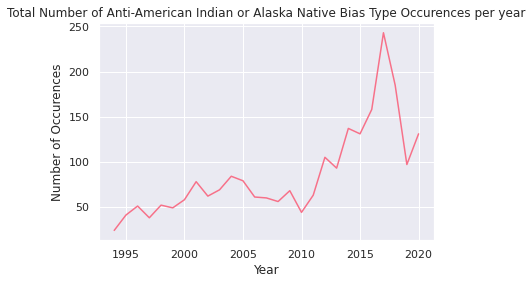

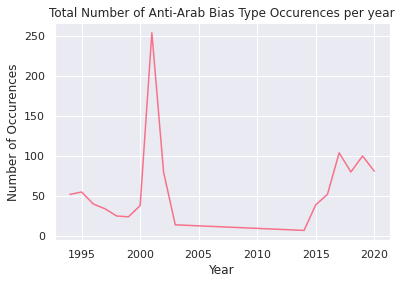

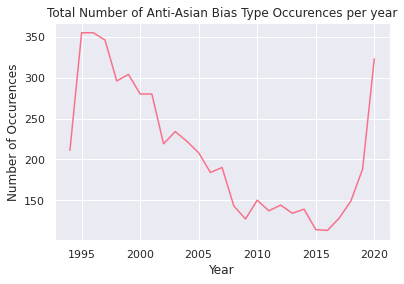

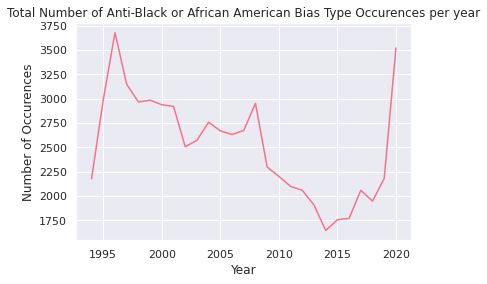

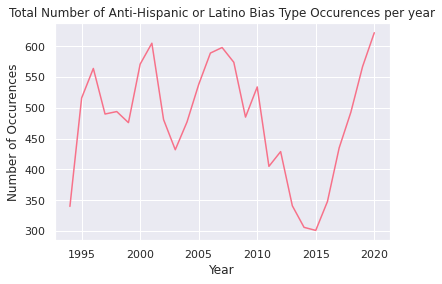

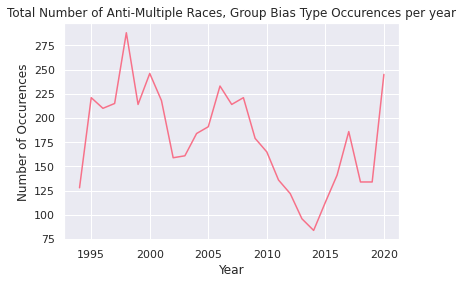

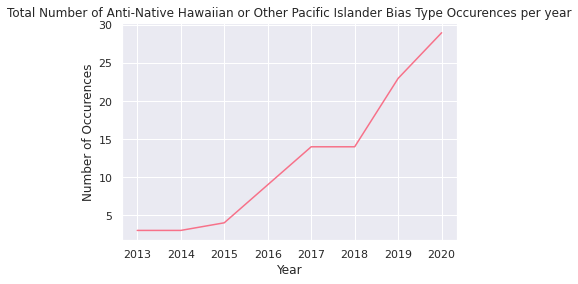

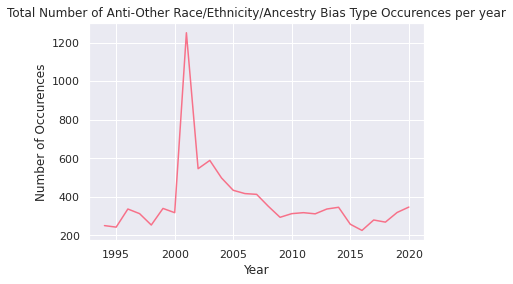

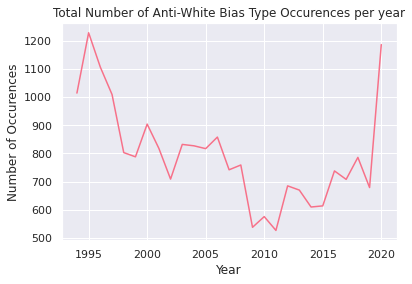

In [28]:
grouped = race_ethnicity_ancestry.groupby(['BIAS_DESC'])
sb.set_palette(colors)
for key in grouped.groups.keys():
    years = grouped.get_group(key)['DATA_YEAR'].value_counts().index
    amount = grouped.get_group(key)['DATA_YEAR'].value_counts()
    sb.lineplot(years,amount)
    plt.xlabel("Year")
    plt.ylabel("Number of Occurences")
    plt.title("Total Number of "+key+" Bias Type Occurences per year")
    plt.show()
    



**religion analysis**

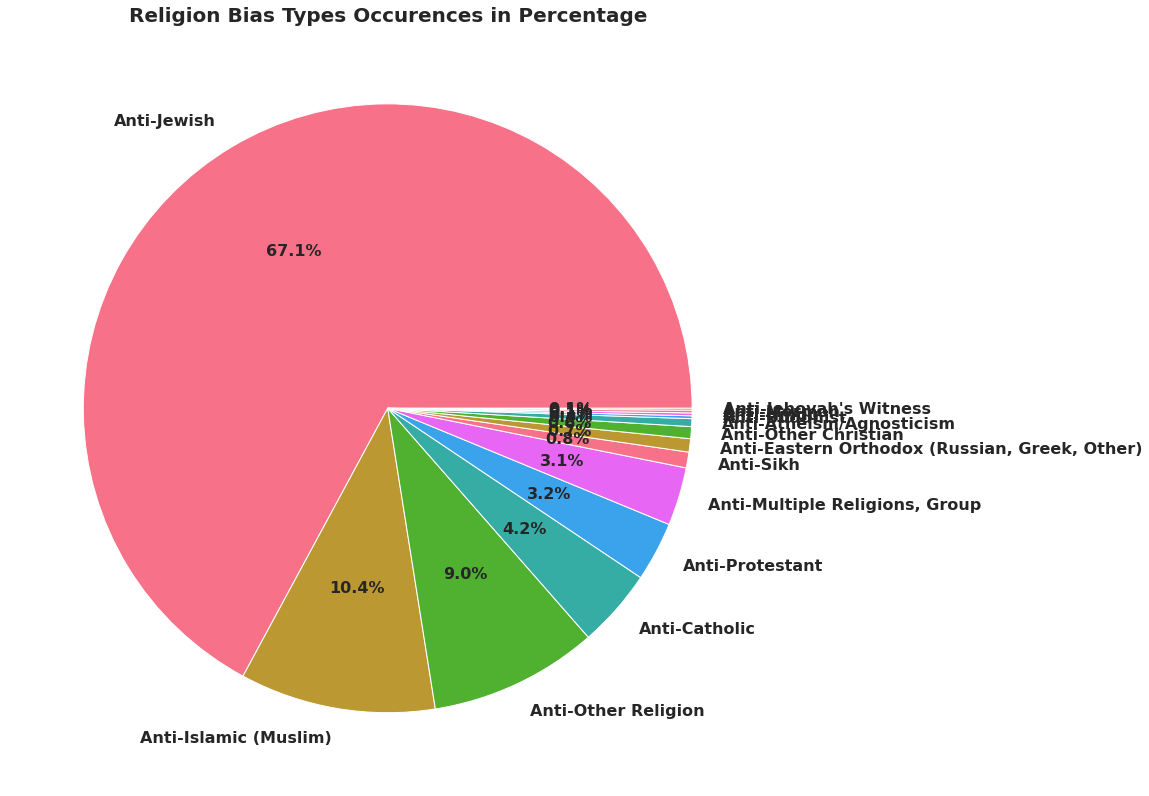

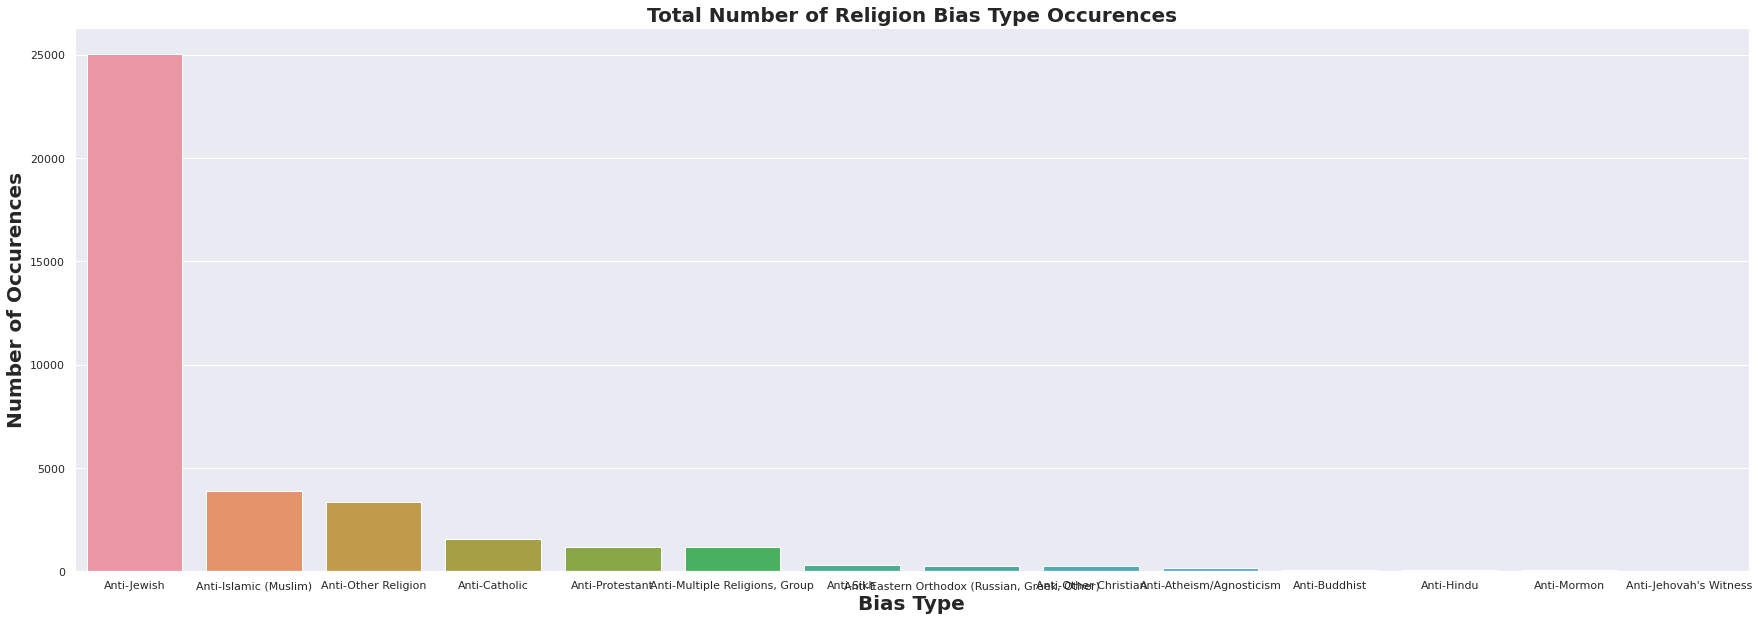

In [29]:
religion= hate_crimes.groupby('BIAS_CATEGORY').get_group('Religion')
x = religion['BIAS_DESC'].value_counts()
y = religion['BIAS_DESC'].value_counts().index

plt.figure(figsize = (14, 14))
plt.pie(x,labels=y,autopct= '%.1f%%',textprops={'fontsize': 16, 'fontweight': "600"},colors=colors)
plt.title("Religion Bias Types Occurences in Percentage",fontsize=20,fontweight= "600")
plt.show()

plt.figure(figsize = (30, 10))
plt.title("Total Number of Religion Bias Type Occurences",fontsize=20,fontweight= "600")
sb.set_palette('husl')

count_bar = sb.barplot(x = y,y=x)
plt.xlabel("Bias Type",fontsize=20,fontweight= "600")
plt.ylabel("Number of Occurences",fontsize=20,fontweight= "600")
plt.show()

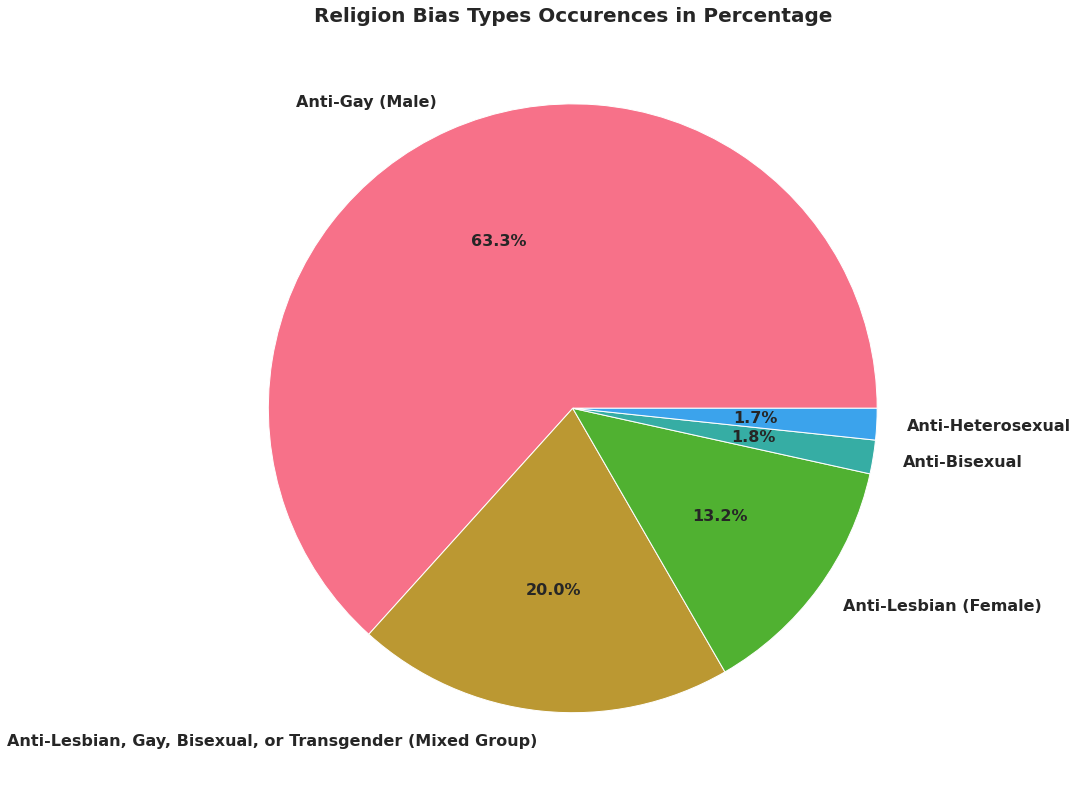

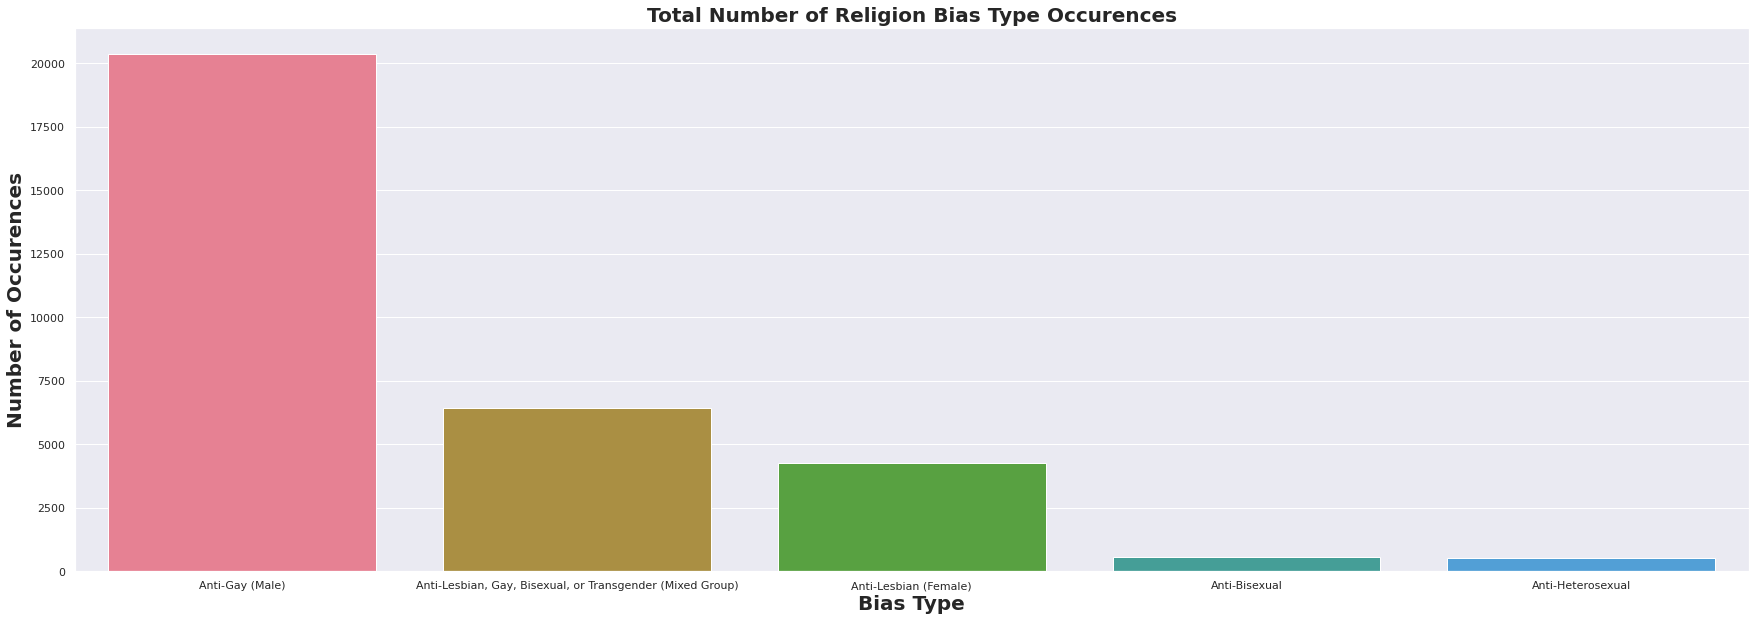

In [30]:
sexual_orientation= hate_crimes.groupby('BIAS_CATEGORY').get_group('Sexual Orientation')
x = sexual_orientation['BIAS_DESC'].value_counts()
y = sexual_orientation['BIAS_DESC'].value_counts().index

plt.figure(figsize = (14, 14))
plt.pie(x,labels=y,autopct= '%.1f%%',textprops={'fontsize': 16, 'fontweight': "600"},colors=colors)
plt.title("Religion Bias Types Occurences in Percentage",fontsize=20,fontweight= "600")
plt.show()

plt.figure(figsize = (30, 10))
plt.title("Total Number of Religion Bias Type Occurences",fontsize=20,fontweight= "600")
sb.set_palette('husl')

count_bar = sb.barplot(x = y,y=x)
plt.xlabel("Bias Type",fontsize=20,fontweight= "600")
plt.ylabel("Number of Occurences",fontsize=20,fontweight= "600")
plt.show()

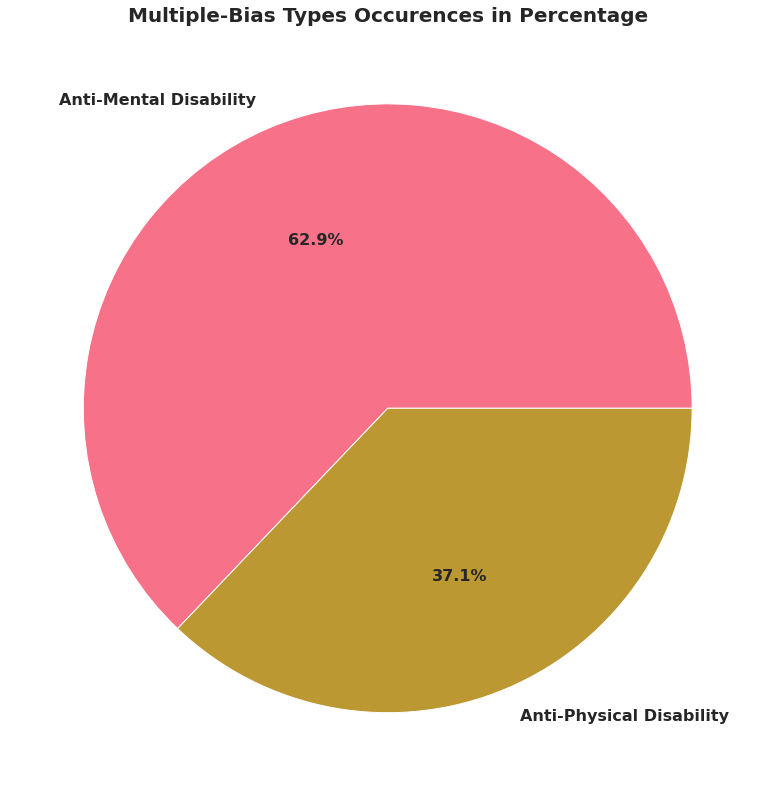

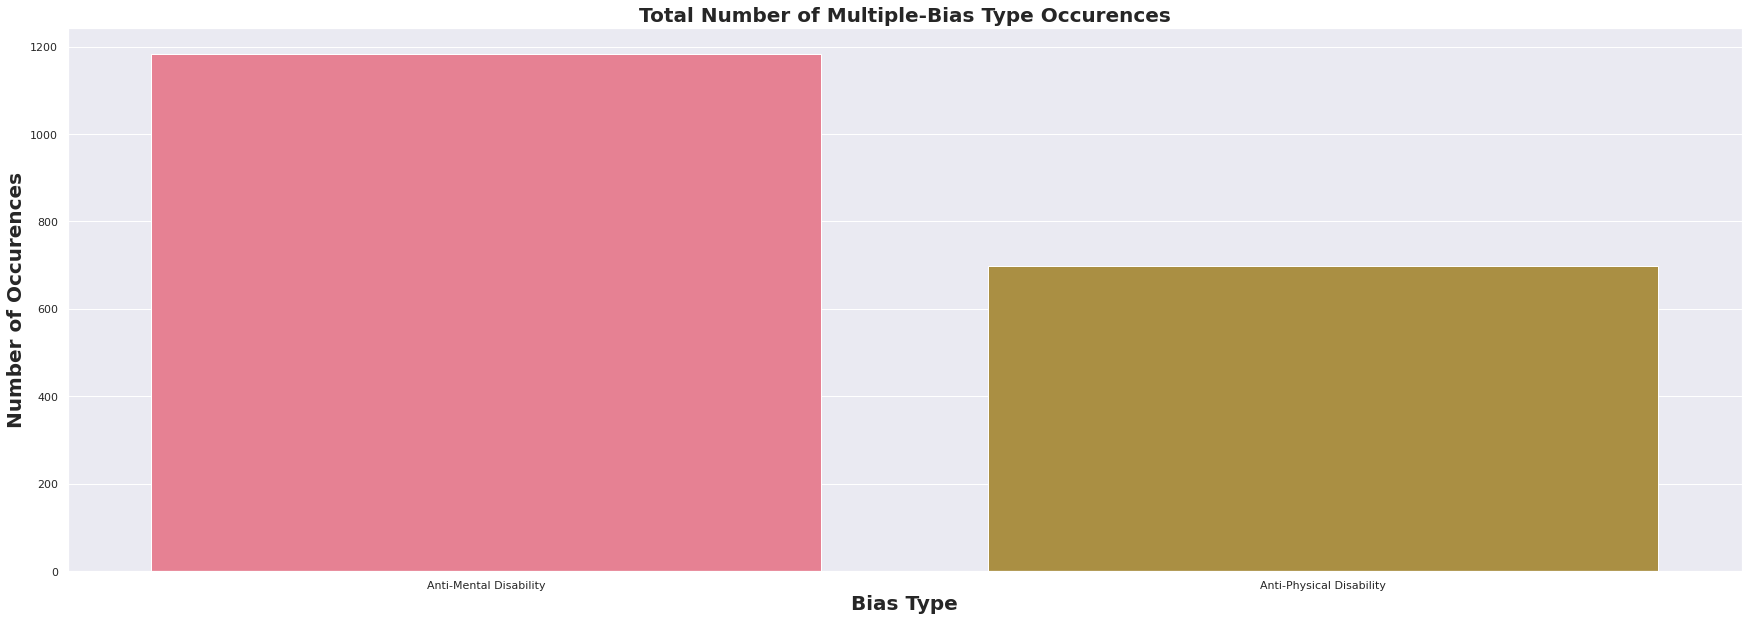

In [31]:
disability= hate_crimes.groupby('BIAS_CATEGORY').get_group('Disability')
x = disability['BIAS_DESC'].value_counts()
y = disability['BIAS_DESC'].value_counts().index

plt.figure(figsize = (14, 14))
plt.pie(x,labels=y,autopct= '%.1f%%',textprops={'fontsize': 16, 'fontweight': "600"},colors=colors)
plt.title("Multiple-Bias Types Occurences in Percentage",fontsize=20,fontweight= "600")
plt.show()

plt.figure(figsize = (30, 10))
plt.title("Total Number of Multiple-Bias Type Occurences",fontsize=20,fontweight= "600")
sb.set_palette('husl')

count_bar = sb.barplot(x = y,y=x,palette= colors)
plt.xlabel("Bias Type",fontsize=20,fontweight= "600")
plt.ylabel("Number of Occurences",fontsize=20,fontweight= "600")
plt.show()

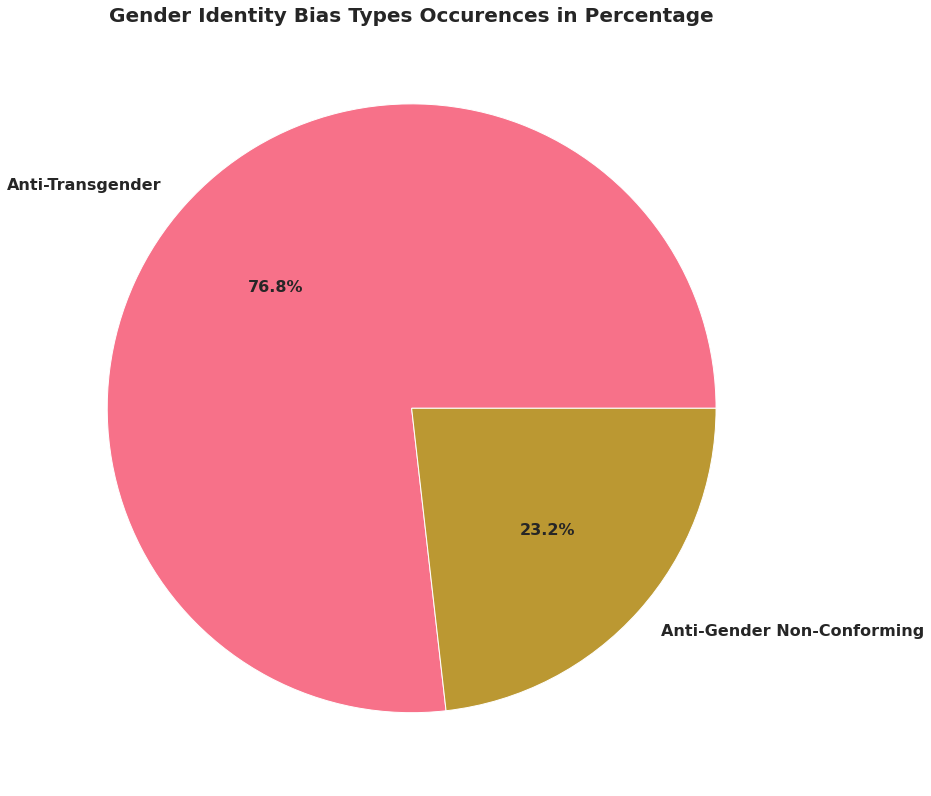

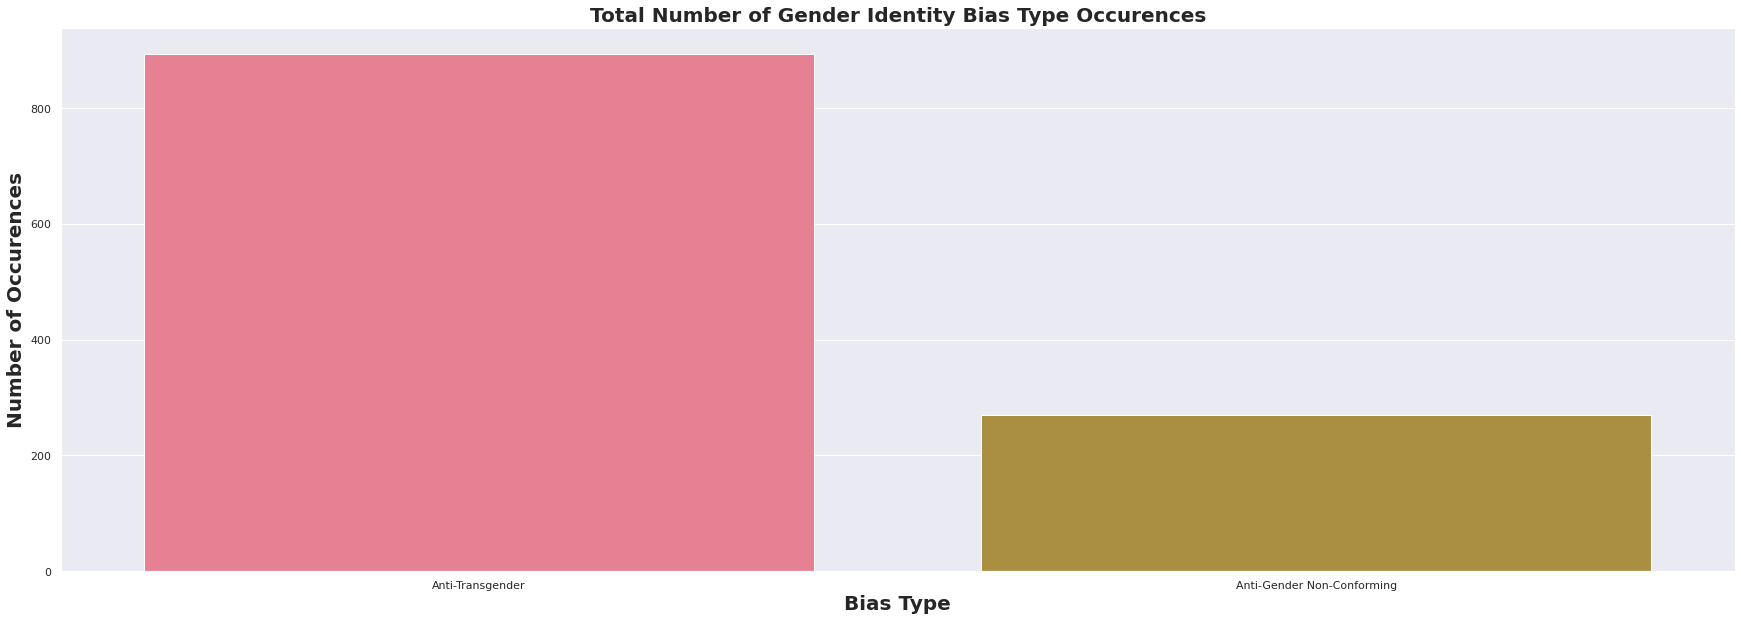

In [32]:
gender_identity= hate_crimes.groupby('BIAS_CATEGORY').get_group('Gender Identity')
x = gender_identity['BIAS_DESC'].value_counts()
y = gender_identity['BIAS_DESC'].value_counts().index

plt.figure(figsize = (14, 14))
plt.pie(x,labels=y,autopct= '%.1f%%',textprops={'fontsize': 16, 'fontweight': "600"},colors=colors)
plt.title("Gender Identity Bias Types Occurences in Percentage",fontsize=20,fontweight= "600")
plt.show()

plt.figure(figsize = (30, 10))
plt.title("Total Number of Gender Identity Bias Type Occurences",fontsize=20,fontweight= "600")
sb.set_palette('husl')

count_bar = sb.barplot(x = y,y=x,palette= colors)
plt.xlabel("Bias Type",fontsize=20,fontweight= "600")
plt.ylabel("Number of Occurences",fontsize=20,fontweight= "600")
plt.show()

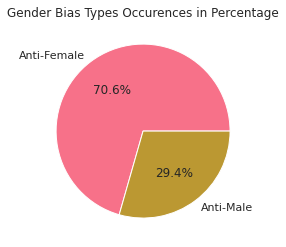

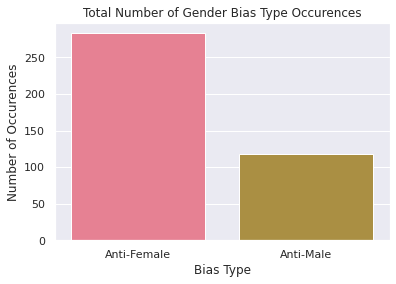

In [33]:
gender= hate_crimes.groupby('BIAS_CATEGORY').get_group('Gender')
x = gender['BIAS_DESC'].value_counts()
y = gender['BIAS_DESC'].value_counts().index

plt.pie(x,labels=y,autopct= '%.1f%%',colors=colors)
plt.title("Gender Bias Types Occurences in Percentage")
plt.show()
plt.title("Total Number of Gender Bias Type Occurences")
count_bar = sb.barplot(x = y,y=x,palette= colors)
plt.xlabel("Bias Type")
plt.ylabel("Number of Occurences")
plt.show()

In [57]:
states=hate_crimes.groupby(['STATE_ABBR', 'BIAS_DESC']).size().reset_index(name='Frequency')
states

,STATE_ABBR,BIAS_DESC,Frequency
0,AK,Anti-American Indian or Alaska Native,48
1,AK,Anti-Arab,1
2,AK,Anti-Asian,7
3,AK,Anti-Black or African American,75
4,AK,Anti-Catholic,1
...,...,...,...
1946,WY,Anti-Native Hawaiian or Other Pacific Islander,1
1947,WY,Anti-Other Race/Ethnicity/Ancestry,4
1948,WY,Anti-Other Religion,4
1949,WY,Anti-Protestant,3


In [58]:
idx = states.groupby(['STATE_ABBR'])['Frequency'].transform(max) == states['Frequency']
bias_by_state = states[idx]
bias_by_state

,STATE_ABBR,BIAS_DESC,Frequency
3,AK,Anti-Black or African American,75
23,AL,Anti-Black or African American,101
45,AR,Anti-Black or African American,352
76,AZ,Anti-Black or African American,2123
138,CA,Anti-Black or African American,11221
194,CO,Anti-Black or African American,1140
235,CT,Anti-Black or African American,1236
269,DC,Anti-Gay (Male),597
291,DE,Anti-Black or African American,378
316,FL,Anti-Black or African American,1575


In [43]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [59]:
import plotly.express as px

fig = px.choropleth(bias_by_state, color="BIAS_DESC", locations="STATE_ABBR", locationmode = 'USA-states', \
                    scope="usa", featureidkey="feature.properties.name", \
                    title="Most Common Bias Group for each State")
fig.show()

## Data Analysis & Hypothesis Testing & ML

## Insight & Policy 